In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/plotting.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/clinical/comprehensive_df.csv', index_col=0)

In [3]:
df.columns

Index([u'classI', u'classII', u'Tissue', u'Age', u'Race', u'homozygous_classI',
       u'homozygous_classII', u'homozygous_total', u'passenger_coverageI',
       u'passenger_coverageII', u'classI_cat', u'classII_cat', u'classI_het',
       u'classII_het', u'B cells naive', u'B cells memory', u'Plasma cells',
       u'T cells CD8', u'T cells CD4 naive', u'T cells CD4 memory resting',
       u'T cells CD4 memory activated', u'T cells follicular helper',
       u'T cells regulatory (Tregs)', u'T cells gamma delta',
       u'NK cells resting', u'NK cells activated', u'Monocytes',
       u'Macrophages M0', u'Macrophages M1', u'Macrophages M2',
       u'Dendritic cells resting', u'Dendritic cells activated',
       u'Mast cells resting', u'Mast cells activated', u'Eosinophils',
       u'Neutrophils', u'P-value', u'Pearson Correlation', u'RMSE', u'GZMA',
       u'PRF1', u'Cytolytic', u'CD4/CD8 Ratio'],
      dtype='object')

In [4]:
df['CD8'] = df['T cells CD8']
df['CD4'] = df['T cells CD4 naive'] + df['T cells CD4 memory resting'] + df['T cells CD4 memory activated']

In [5]:
df['CD8'].describe()

count    4649.000000
mean        0.065156
std         0.069755
min         0.000000
25%         0.010835
50%         0.048578
75%         0.094506
max         0.672565
Name: CD8, dtype: float64

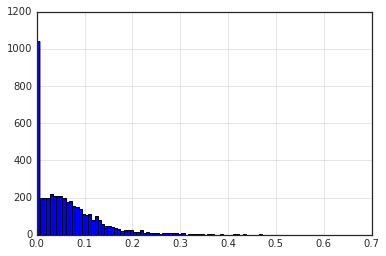

In [6]:
df['CD8'].hist(bins=100)

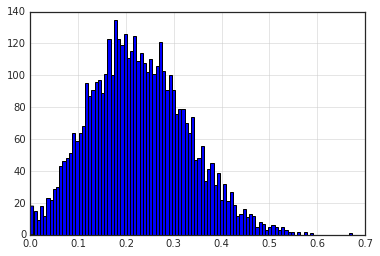

In [7]:
df['CD4'].hist(bins=100)

In [8]:
subset = 'inclusive'

In [9]:
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_mutations.cancer.TCGA.{0}.mut.csv'.format(subset),
                              index_col=0)
patient_affinitiesI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.cancer.TCGA.{0}.mut.ClassI.csv'.format(subset),
                              index_col=0)
patient_affinitiesII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.cancer.TCGA.{0}.mut.ClassII.csv'.format(subset),
                              index_col=0)

In [10]:
# by tissue-specific medians
for cell in ['CD4', 'CD8']:
    patient_tissues = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_tissues.{0}.csv'.format(subset),
                                  index_col=0)
    low_exp_patients_by_tissue, high_exp_patients_by_tissue = [], []
    for tissue in patient_tissues.Tissue.unique():
        tissue_patients = list(patient_tissues[patient_tissues.Tissue == tissue].index)
        tissue_df = df.ix[tissue_patients].dropna()
        if len(tissue_df) > 4:
            low_exp_patients_by_tissue.extend(list(tissue_df[tissue_df[cell] < tissue_df[cell].quantile(.3)].index))
            high_exp_patients_by_tissue.extend(list(tissue_df[tissue_df[cell] > tissue_df[cell].quantile(.7)].index))
    print len(low_exp_patients_by_tissue), len(high_exp_patients_by_tissue)
    patient_mutations.ix[low_exp_patients_by_tissue, :].to_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_mutations.low_{0}_by_tissue.TCGA.{1}.mut.csv'.format(cell, subset))
    patient_affinitiesI.ix[low_exp_patients_by_tissue, :].to_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.low_{0}_by_tissue.TCGA.{1}.mut.ClassI.csv'.format(cell, subset))
    patient_affinitiesII.ix[low_exp_patients_by_tissue, :].to_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.low_{0}_by_tissue.TCGA.{1}.mut.ClassII.csv'.format(cell, subset))
    patient_mutations.ix[high_exp_patients_by_tissue, :].to_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_mutations.high_{0}_by_tissue.TCGA.{1}.mut.csv'.format(cell, subset))
    patient_affinitiesI.ix[high_exp_patients_by_tissue, :].to_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.high_{0}_by_tissue.TCGA.{1}.mut.ClassI.csv'.format(cell, subset))
    patient_affinitiesII.ix[high_exp_patients_by_tissue, :].to_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.high_{0}_by_tissue.TCGA.{1}.mut.ClassII.csv'.format(cell, subset))

1081 1083
928 1083


###Difference in patient selection

In [33]:
def plot_pan_comparison_by_subject(pan, cat, outfile):
    cat_name1, cat_name2 = pan[cat].unique()    
    pan['Error'] = pan['OR'] - pan['conf_OR_low']
    plt.figure(figsize=(3.5, 2.5))
    #plt.axvline(1, color='lightgrey')
    plt.errorbar(pan[pan[cat] == cat_name1].OR, [x + 0.1 for x in range(len(pan[pan[cat] == cat_name1]))[::-1]], 
                 xerr=list(pan[pan[cat] == cat_name1].Error), fmt='o', 
                 color='k', label='MHC-I')
    plt.errorbar(pan[pan[cat] == cat_name2].OR, [x - 0.1 for x in range(len(pan[pan[cat] == cat_name2]))[::-1]], 
                 xerr=list(pan[pan[cat] == cat_name2].Error), fmt='o', 
                 color='grey', label='MHC-II')
    plt.yticks([1, 0], list(pan[pan[cat] == cat_name2].Condition))
    plt.ylabel('')
    plt.xlabel('Odds ratio')
    plt.ylim(-0.5, 1.5)
    plt.legend(loc=7)
    if outfile != None:
        plt.savefig(outfile, bbox_inches='tight')
    return plt

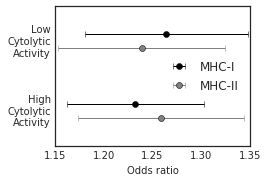

In [34]:
# by tissue
subset = 'conservative'
for cell in ['cytolytic']:
    classes = ['class_i', 'class_ii']
    all_dfs = []
    for c in classes:
        for f, name in zip(['low_{0}_by_tissue.{1}.thresh_2.txt'.format(cell, subset),
                            'high_{0}_by_tissue.{1}.thresh_2.txt'.format(cell, subset)],
                           ['Low\n{0}\nActivity'.format(cell.title()), 'High\n{0}\nActivity'.format(cell.title())]): 
            tmp = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR_clean/pan/{0}/{1}'.format(c, f),
                   sep=' ')
            tmp['Class'] = c
            tmp['Condition'] = name
            all_dfs.append(tmp)
    pan = pd.concat(all_dfs)
    plot = plot_pan_comparison_by_subject(pan, 'Class', 
                               '/cellar/users/ramarty/Data/hla_ii/generated_figures/mutations/{0}_by_tissue.pan_OR.pdf'.format(cell))
    plt.show()
    plt.clf()

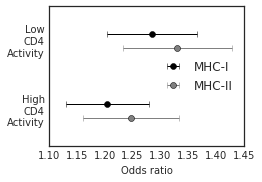

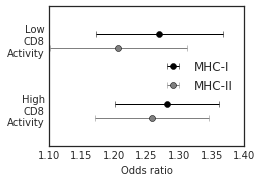

In [35]:
# by tissue
subset = 'conservative'
for cell in ['CD4', 'CD8']:
    classes = ['class_i', 'class_ii']
    all_dfs = []
    for c in classes:
        for f, name in zip(['low_{0}_by_tissue.{1}.thresh_2.txt'.format(cell, subset),
                            'high_{0}_by_tissue.{1}.thresh_2.txt'.format(cell, subset)],
                           ['Low\n{0}\nActivity'.format(cell), 'High\n{0}\nActivity'.format(cell)]): 
            tmp = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR_clean/pan/{0}/{1}'.format(c, f),
                   sep=' ')
            tmp['Class'] = c
            tmp['Condition'] = name
            all_dfs.append(tmp)
    pan = pd.concat(all_dfs)
    plot = plot_pan_comparison_by_subject(pan, 'Class', 
                               '/cellar/users/ramarty/Data/hla_ii/generated_figures/mutations/{0}_by_tissue.pan_OR.pdf'.format(cell))
    plt.show()
    plt.clf()

###Distribution of coverage

In [25]:
plotting = pd.DataFrame({'Presentation Coverage of Driver Space': list(df.loc[low_exp_patients_by_tissue].classII) + list(df.loc[high_exp_patients_by_tissue].classII),
                         'APC Infiltration': ['Low' for x in list(df.loc[low_exp_patients_by_tissue].index)] + ['High' for x in list(df.loc[high_exp_patients_by_tissue].index)]})


In [26]:
statistic, p = sp.mannwhitneyu(df.loc[low_exp_patients_by_tissue].classII,
                df.loc[high_exp_patients_by_tissue].classII)

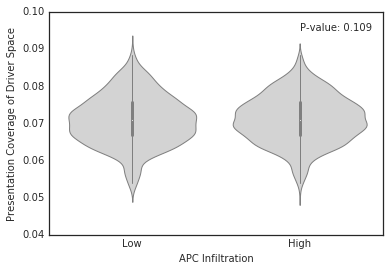

In [27]:
sns.violinplot(x='APC Infiltration', y='Presentation Coverage of Driver Space', data=plotting,
              color='lightgrey')
plt.text(1, .095, 'P-value: {0}'.format(round(p, 3)))
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/mutations/Cytolytic_by_tissue.coverage.pdf')

In [28]:
df.loc[low_exp_patients_by_tissue].classII.describe()

count    1298.000000
mean        0.070857
std         0.006718
min         0.052063
25%         0.066798
50%         0.070727
75%         0.075639
max         0.090373
Name: classII, dtype: float64

In [29]:
df.loc[high_exp_patients_by_tissue].classII.describe()

count    1299.000000
mean        0.071114
std         0.006403
min         0.051081
25%         0.066798
50%         0.070727
75%         0.075639
max         0.088409
Name: classII, dtype: float64

###Patient-specific relationships

Coverage scores w/ immune metric

In [34]:
df = df.dropna()

In [39]:
df.columns[14:]

Index([u'B cells naive', u'B cells memory', u'Plasma cells', u'T cells CD8',
       u'T cells CD4 naive', u'T cells CD4 memory resting',
       u'T cells CD4 memory activated', u'T cells follicular helper',
       u'T cells regulatory (Tregs)', u'T cells gamma delta',
       u'NK cells resting', u'NK cells activated', u'Monocytes',
       u'Macrophages M0', u'Macrophages M1', u'Macrophages M2',
       u'Dendritic cells resting', u'Dendritic cells activated',
       u'Mast cells resting', u'Mast cells activated', u'Eosinophils',
       u'Neutrophils', u'P-value', u'Pearson Correlation', u'RMSE', u'GZMA',
       u'PRF1', u'Cytolytic', u'CD4/CD8 Ratio'],
      dtype='object')

In [47]:
for infiltrate in df.columns[14:]:
    if sp.spearmanr(df[infiltrate], df.classI)[1] < 0.05:
        print infiltrate, sp.spearmanr(df[infiltrate], df.classI)

T cells follicular helper SpearmanrResult(correlation=-0.031952977316932668, pvalue=0.035935284234662912)
Neutrophils SpearmanrResult(correlation=0.044353291234371275, pvalue=0.003586534612076094)


In [48]:
for infiltrate in df.columns[14:]:
    if sp.spearmanr(df[infiltrate], df.classII)[1] < 0.05:
        print infiltrate, sp.spearmanr(df[infiltrate], df.classII)

Min clonal PHBR w/immune metrics

In [46]:
patient_mutations

,EGFR_ifd_55174772,NOTCH1_ifd_136518618,PIK3R1_ifd_68295304,CTNNB1_ifd_41224643,PIK3R1_ifd_68293795,ERBB2_ifi_39724728,EGFR_ifd_55174773,PIK3R1_ifd_68293758,TP53_ifd_7675066,BRAF_ifd_140778037,...,THRAP3_R504W,KMT2C_W430C,KMT2B_R1597Q,PIK3R1_L573P,KMT2C_D4425Y,TCF12_R589H,TP53_A161D,KEAP1_V155F,NF1_P1990Q,TP53_I254S
TCGA-02-0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-04-1331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
